# Knowledge Graph Visualization for PQuad Dataset

This notebook visualizes the knowledge graph created by the HippoRAG system for the PQuad dataset. The graph contains entities extracted from Persian text and their relationships, including both explicit relations and synonymy connections based on semantic similarity.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load the knowledge graph data
with open("hippocampal_index.json", 'r', encoding='utf-8') as f:
    graph_data = json.load(f)

# Load the source triples for additional analysis
with open("knowledge_graph_triples_structured.json", 'r', encoding='utf-8') as f:
    source_triples = json.load(f)

print(f"Knowledge Graph loaded:")
print(f"- Nodes: {len(graph_data['nodes'])}")
print(f"- Edges: {len(graph_data['edges'])}")
print(f"- Source passages: {len(source_triples)}")

# Basic statistics
relation_edges = [e for e in graph_data['edges'] if e['type'] == 'relation']
synonymy_edges = [e for e in graph_data['edges'] if e['type'] == 'synonymy']

print("---" * 10)
print(f"- Relation edges: {len(relation_edges)}")
print(f"- Synonymy edges: {len(synonymy_edges)}")

Knowledge Graph loaded:
- Nodes: 4691
- Edges: 4657
- Source passages: 300
------------------------------
- Relation edges: 4329
- Synonymy edges: 328


## Graph Statistics and Analysis

In [3]:
# Create NetworkX graph for analysis
G = nx.Graph()

# Add nodes
for node in graph_data['nodes']:
    G.add_node(node['id'], label=node['label'])

# Add edges
for edge in graph_data['edges']:
    source_id = None
    target_id = None
    
    for node in graph_data['nodes']:
        if node['label'] == edge['source']:
            source_id = node['id']
        if node['label'] == edge['target']:
            target_id = node['id']
    
    if source_id is not None and target_id is not None:
        edge_attrs = {'type': edge['type']}
        if edge['type'] == 'synonymy':
            edge_attrs['score'] = edge.get('score', 0.8)
        else:
            edge_attrs['label'] = edge.get('label', 'relation')
        G.add_edge(source_id, target_id, **edge_attrs)

print(f"- Nodes: {G.number_of_nodes()}")
print(f"- Edges: {G.number_of_edges()}")
print(f"- Connected components: {nx.number_connected_components(G)}")
print(f"- Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

# Calculate degree statistics
degrees = dict(G.degree())
print(f"- Max degree: {max(degrees.values())}")
print(f"- Min degree: {min(degrees.values())}")

# Find nodes with highest degrees (most connected entities)
top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 most connected entities:")
for node_id, degree in top_nodes:
    label = G.nodes[node_id]['label']
    print(f"  {label}: {degree}")

- Nodes: 4691
- Edges: 4480
- Connected components: 578
- Average degree: 1.91
- Max degree: 51
- Min degree: 0

Top 10 most connected entities:
  ژاپن: 51
  ایران: 42
  قرآن: 42
  گیلان: 41
  مورینیو: 36
  اردشیر: 34
  کندی: 30
  ترون: 29
  پورتمن: 28
  اردشیر بابکان: 27


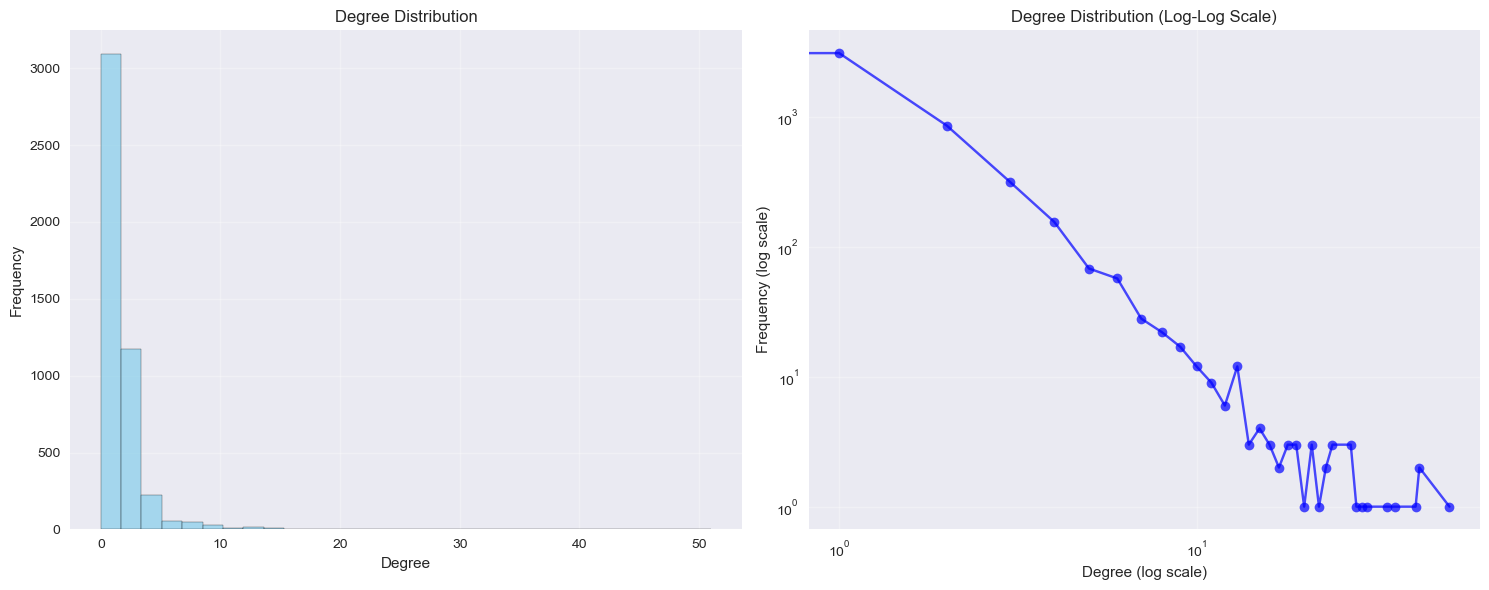

- Mean degree: 1.91
- Median degree: 1.00
- Standard deviation: 2.64
- Isolated nodes (degree 0): 1
- Highly connected nodes (degree > 10): 67


In [4]:
degree_sequence = list(degrees.values())
degree_counts = Counter(degree_sequence)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram of degrees
ax1.hist(degree_sequence, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Degree')
ax1.set_ylabel('Frequency')
ax1.set_title('Degree Distribution')
ax1.grid(True, alpha=0.3)

# Log-log plot
degrees_sorted = sorted(degree_counts.keys())
counts_sorted = [degree_counts[d] for d in degrees_sorted]

ax2.loglog(degrees_sorted, counts_sorted, 'bo-', alpha=0.7)
ax2.set_xlabel('Degree (log scale)')
ax2.set_ylabel('Frequency (log scale)')
ax2.set_title('Degree Distribution (Log-Log Scale)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"- Mean degree: {np.mean(degree_sequence):.2f}")
print(f"- Median degree: {np.median(degree_sequence):.2f}")
print(f"- Standard deviation: {np.std(degree_sequence):.2f}")
print(f"- Isolated nodes (degree 0): {sum(1 for d in degree_sequence if d == 0)}")
print(f"- Highly connected nodes (degree > 10): {sum(1 for d in degree_sequence if d > 10)}")

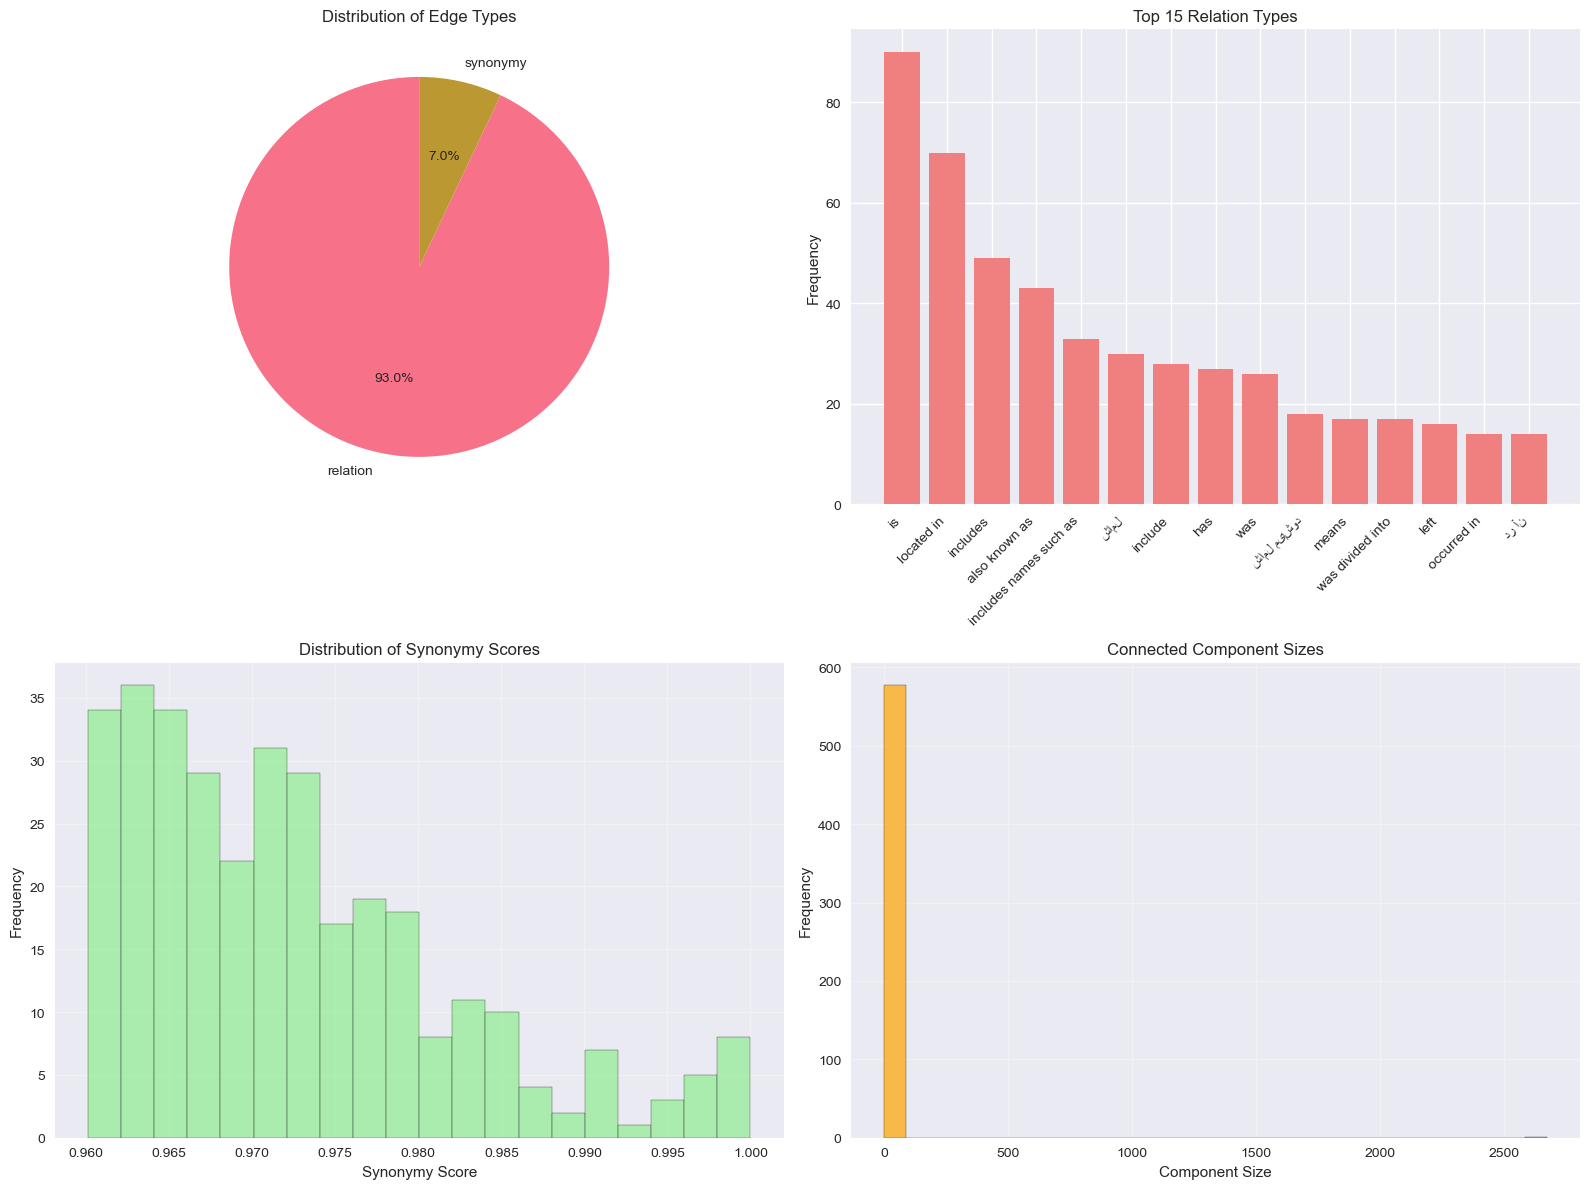

- Total edges: 4657
- Relation edges: 4329
- Synonymy edges: 328
- Average synonymy score: 0.972
- Min synonymy score: 0.960
- Max synonymy score: 1.000
- Largest connected component: 2674 nodes
- Number of isolated nodes: 8


In [5]:
# Edge type analysis
edge_types = [edge['type'] for edge in graph_data['edges']]
edge_type_counts = Counter(edge_types)

# Analyze relation edge labels
relation_labels = [edge.get('label', 'unknown') for edge in graph_data['edges'] if edge['type'] == 'relation']
relation_label_counts = Counter(relation_labels)

# Analyze synonymy scores
synonymy_scores = [edge.get('score', 0) for edge in graph_data['edges'] if edge['type'] == 'synonymy']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Edge type distribution
ax1.pie(edge_type_counts.values(), labels=edge_type_counts.keys(), autopct='%1.1f%%', startangle=90)
ax1.set_title('Distribution of Edge Types')

# Top relation labels
if relation_label_counts:
    top_relations = dict(relation_label_counts.most_common(15))
    ax2.bar(range(len(top_relations)), list(top_relations.values()), color='lightcoral')
    ax2.set_xticks(range(len(top_relations)))
    ax2.set_xticklabels(list(top_relations.keys()), rotation=45, ha='right')
    ax2.set_title('Top 15 Relation Types')
    ax2.set_ylabel('Frequency')

# Synonymy score distribution
if synonymy_scores:
    ax3.hist(synonymy_scores, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    ax3.set_xlabel('Synonymy Score')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Synonymy Scores')
    ax3.grid(True, alpha=0.3)

# Component size distribution
component_sizes = [len(c) for c in nx.connected_components(G)]
ax4.hist(component_sizes, bins=30, alpha=0.7, color='orange', edgecolor='black')
ax4.set_xlabel('Component Size')
ax4.set_ylabel('Frequency')
ax4.set_title('Connected Component Sizes')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"- Total edges: {len(graph_data['edges'])}")
print(f"- Relation edges: {edge_type_counts.get('relation', 0)}")
print(f"- Synonymy edges: {edge_type_counts.get('synonymy', 0)}")
if synonymy_scores:
    print(f"- Average synonymy score: {np.mean(synonymy_scores):.3f}")
    print(f"- Min synonymy score: {min(synonymy_scores):.3f}")
    print(f"- Max synonymy score: {max(synonymy_scores):.3f}")
print(f"- Largest connected component: {max(component_sizes)} nodes")
print(f"- Number of isolated nodes: {sum(1 for size in component_sizes if size == 1)}")

## Graph Visualizations

### Interactive Network Visualization with Plotly

In [6]:
# visualize the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc).copy()

print(f"Visualizing largest connected component with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")

# Create layout
pos = nx.spring_layout(subgraph, k=1, iterations=50)

# Prepare edge traces
edge_x = []
edge_y = []
edge_info = []

for edge in subgraph.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    
    edge_type = edge[2].get('type', 'unknown')
    if edge_type == 'synonymy':
        score = edge[2].get('score', 'N/A')
        edge_info.append(f"Synonymy (score: {score})")
    else:
        label = edge[2].get('label', 'relation')
        edge_info.append(f"Relation: {label}")

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Prepare node traces
node_x = []
node_y = []
node_text = []
node_color = []
node_size = []

for node in subgraph.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    
    # Get node information
    label = subgraph.nodes[node]['label']
    degree = subgraph.degree(node)
    
    node_text.append(f"{label}<br>Degree: {degree}")
    # Color by degree
    node_color.append(degree)  
    # Size by degree
    node_size.append(10 + degree * 2)  

# Create node trace
node_trace = go.Scatter(x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[subgraph.nodes[node]['label'] for node in subgraph.nodes()],
    textposition="middle center",
    textfont=dict(size=8),
    hovertext=node_text,
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Node Degree"),
        line=dict(width=1, color='black')
        )
)

fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
    title=f'Knowledge Graph Visualization (Subgraph with {subgraph.number_of_nodes()} nodes)',
    titlefont_size=16,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=5,r=5,t=40),
    annotations=[
        dict(
            text="Node size and color represent degree centrality",
            showarrow=False,
            xref="paper", yref="paper",
            x=0.005, y=-0.002,
            xanchor="left", yanchor="bottom",
            font=dict(size=12)
        )
    ],
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    width=1000,
    height=800)
)

fig.show()

Visualizing largest connected component with 2674 nodes and 2997 edges


In [7]:
# visualize the largest connected component, This time with sampling the highest-degree nodes and their neighbours
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc).copy()

print(f"Visualizing largest connected component with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")


# Take nodes with highest degrees plus their neighbors (100 highest degree nodes)
high_degree_nodes = sorted(subgraph.degree(), key=lambda x: x[1], reverse=True)[:100]
nodes_to_include = set(node for node, degree in high_degree_nodes)

# Add neighbors of high-degree nodes
for node, _ in high_degree_nodes:
    nodes_to_include.update(subgraph.neighbors(node))

subgraph = subgraph.subgraph(list(nodes_to_include)[:]).copy()
print(f"Sampled subgraph with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")

# Create layout
pos = nx.spring_layout(subgraph, k=1, iterations=50)

# Prepare edge traces
edge_x = []
edge_y = []
edge_info = []

for edge in subgraph.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    
    edge_type = edge[2].get('type', 'unknown')
    if edge_type == 'synonymy':
        score = edge[2].get('score', 'N/A')
        edge_info.append(f"Synonymy (score: {score})")
    else:
        label = edge[2].get('label', 'relation')
        edge_info.append(f"Relation: {label}")

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Prepare node traces
node_x = []
node_y = []
node_text = []
node_color = []
node_size = []

for node in subgraph.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    
    # Get node information
    label = subgraph.nodes[node]['label']
    degree = subgraph.degree(node)
    
    node_text.append(f"{label}<br>Degree: {degree}")
    node_color.append(degree)  # Color by degree
    node_size.append(10 + degree * 2)  # Size by degree

# Create node trace
node_trace = go.Scatter(x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[subgraph.nodes[node]['label'] for node in subgraph.nodes()],
    textposition="middle center",
    textfont=dict(size=8),
    hovertext=node_text,
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Node Degree"),
        line=dict(width=1, color='black')
        )
)

# Create the figure
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
    title=f'Knowledge Graph Visualization (Subgraph with {subgraph.number_of_nodes()} nodes)',
    titlefont_size=16,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=5,r=5,t=40),
    annotations=[ dict(
        text="Node size and color represent degree centrality",
        showarrow=False,
        xref="paper", yref="paper",
        x=0.005, y=-0.002,
        xanchor="left", yanchor="bottom",
        font=dict(size=12)
    )],
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    width=1000,
    height=800)
)

fig.show()

Visualizing largest connected component with 2674 nodes and 2997 edges
Sampled subgraph with 1429 nodes and 1561 edges


In [8]:
# visualize a smaller connected component
ccs = list(nx.connected_components(G))
ccs.sort(key=lambda x: len(x))


subgraph = G.subgraph(ccs[-2]).copy()

print(f"Visualizing the smaller connected component with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")

# Create layout
pos = nx.spring_layout(subgraph, k=1, iterations=50)

# Prepare edge traces
edge_x = []
edge_y = []
edge_info = []

for edge in subgraph.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    
    edge_type = edge[2].get('type', 'unknown')
    if edge_type == 'synonymy':
        score = edge[2].get('score', 'N/A')
        edge_info.append(f"Synonymy (score: {score})")
    else:
        label = edge[2].get('label', 'relation')
        edge_info.append(f"Relation: {label}")

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Prepare node traces
node_x = []
node_y = []
node_text = []
node_color = []
node_size = []

for node in subgraph.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    
    # Get node information
    label = subgraph.nodes[node]['label']
    degree = subgraph.degree(node)
    
    node_text.append(f"{label}<br>Degree: {degree}")
    # Color by degree
    node_color.append(degree)  
    # Size by degree
    node_size.append(10 + degree * 2)  

# Create node trace
node_trace = go.Scatter(x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[subgraph.nodes[node]['label'] for node in subgraph.nodes()],
    textposition="middle center",
    textfont=dict(size=8),
    hovertext=node_text,
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Node Degree"),
        line=dict(width=1, color='black')
        )
)

fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
    title=f'Knowledge Graph Visualization (Subgraph with {subgraph.number_of_nodes()} nodes)',
    titlefont_size=16,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=5,r=5,t=40),
    annotations=[ dict(
        text="Node size and color represent degree centrality",
        showarrow=False,
        xref="paper", yref="paper",
        x=0.005, y=-0.002,
        xanchor="left", yanchor="bottom",
        font=dict(size=12)
    )],
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    width=1000,
    height=800)
)

fig.show()

Visualizing the smaller connected component with 63 nodes and 63 edges


### Centrality Analysis

Analyzing different centrality measures to identify important entities in the knowledge graph.

In [9]:
# Calculate different centrality measures for the largest connected component
lcc_graph = G.subgraph(largest_cc)

# Calculate centrality measures
degree_centrality = nx.degree_centrality(lcc_graph)
betweenness_centrality = nx.betweenness_centrality(lcc_graph, k=min(100, len(lcc_graph)))  # Sample for large graphs
closeness_centrality = nx.closeness_centrality(lcc_graph)

# Get top entities for each centrality measure
def get_top_entities(centrality_dict, n=10):
    return sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:n]

top_degree = get_top_entities(degree_centrality)
top_betweenness = get_top_entities(betweenness_centrality)
top_closeness = get_top_entities(closeness_centrality)

# Display results
print("\n" + "="*50)
print("TOP ENTITIES BY CENTRALITY MEASURES")
print("="*50)

print("\nTop 10 by Degree Centrality (most connected):")
for node_id, score in top_degree:
    label = lcc_graph.nodes[node_id]['label']
    print(f"  {label}: {score:.4f}")

print("\nTop 10 by Betweenness Centrality (bridges/brokers):")
for node_id, score in top_betweenness:
    label = lcc_graph.nodes[node_id]['label']
    print(f"  {label}: {score:.4f}")

print("\nTop 10 by Closeness Centrality (central position):")
for node_id, score in top_closeness:
    label = lcc_graph.nodes[node_id]['label']
    print(f"  {label}: {score:.4f}")


TOP ENTITIES BY CENTRALITY MEASURES

Top 10 by Degree Centrality (most connected):
  ژاپن: 0.0191
  ایران: 0.0157
  قرآن: 0.0157
  گیلان: 0.0153
  مورینیو: 0.0135
  اردشیر: 0.0127
  کندی: 0.0112
  ترون: 0.0108
  پورتمن: 0.0105
  اردشیر بابکان: 0.0101

Top 10 by Betweenness Centrality (bridges/brokers):
  ایران: 0.4512
  ژاپن: 0.1726
  گیلان: 0.1628
  رضاخان: 0.1321
  قرآن: 0.1278
  پورتمن: 0.1068
  خورشید: 0.1059
  ارامنه: 0.1015
  چین: 0.0999
  برهان: 0.0869

Top 10 by Closeness Centrality (central position):
  ایران: 0.1788
  گیلان: 0.1647
  رضاخان: 0.1619
  چین: 0.1607
  مشروطه‌طلبان: 0.1594
  صدا و سیمای مرکز گیلان: 0.1588
  فارسی: 0.1587
  دارالفنون: 0.1584
  دبیرستان البرز: 0.1578
  آمریکا: 0.1578


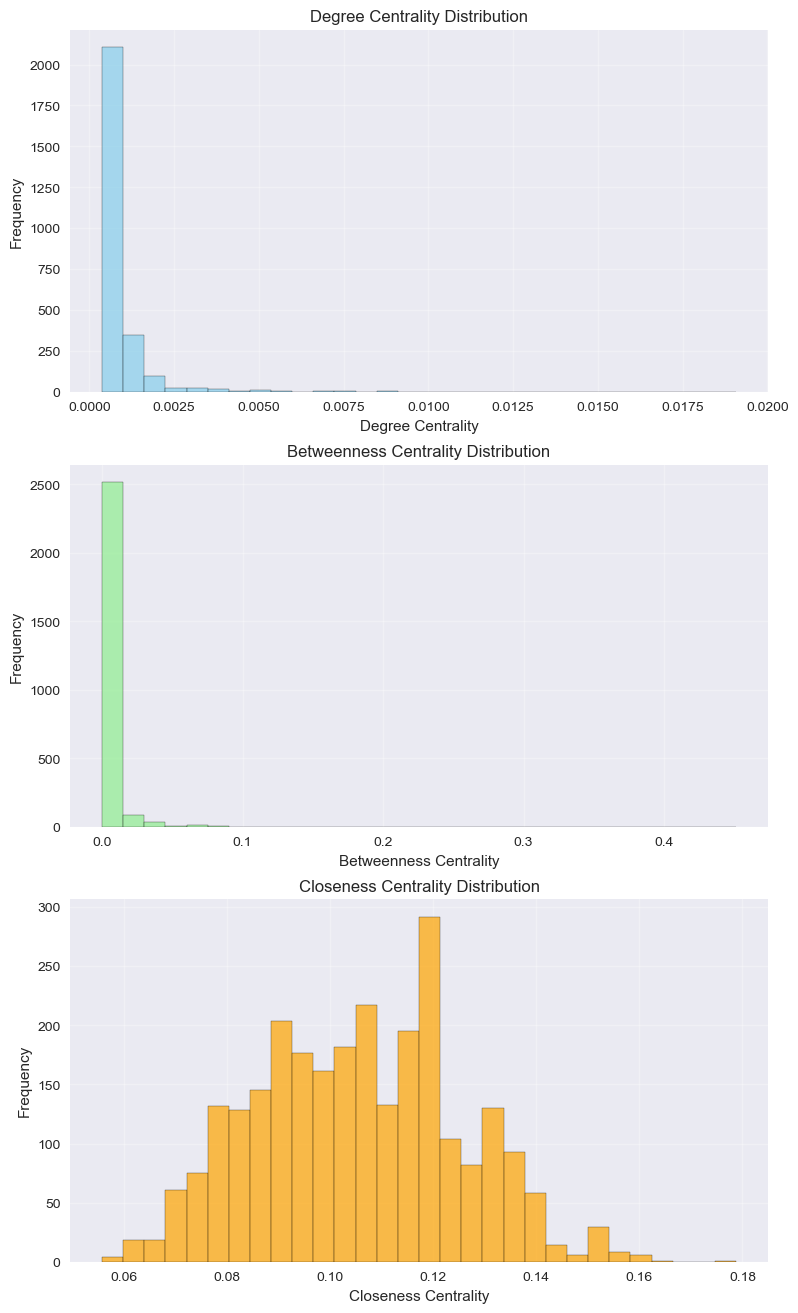

In [10]:
# Visualize centrality distributions
fig, axes = plt.subplots(3, 1, figsize=(9, 16))

# Degree centrality
axes[0].hist(list(degree_centrality.values()), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Degree Centrality Distribution')
axes[0].set_xlabel('Degree Centrality')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Betweenness centrality
axes[1].hist(list(betweenness_centrality.values()), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_title('Betweenness Centrality Distribution')
axes[1].set_xlabel('Betweenness Centrality')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# Closeness centrality
axes[2].hist(list(closeness_centrality.values()), bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[2].set_title('Closeness Centrality Distribution')
axes[2].set_xlabel('Closeness Centrality')
axes[2].set_ylabel('Frequency')
axes[2].grid(True, alpha=0.3)

### Entity Co-occurrence Analysis

Analyzing which entities frequently appear together in the same passages.

Entity frequency analysis:
- Total unique entities: 5291
- Entities appearing in multiple passages: 320
- Most frequent entities:
  ایران: appears in 48 passages
  آمریکا: appears in 15 passages
  ژاپن: appears in 10 passages
  هادی: appears in 9 passages
  تهران: appears in 8 passages
  فرانسه: appears in 8 passages
  اروپا: appears in 8 passages
  روم: appears in 8 passages
  دولت: appears in 7 passages
  گیلان: appears in 7 passages
  فارسی: appears in 7 passages
  اکسیژن: appears in 7 passages
  مصر: appears in 7 passages
  مورینیو: appears in 7 passages
  گوگل: appears in 7 passages

Passage entity statistics:
- Average entities per passage: 19.75
- Median entities per passage: 19.00
- Max entities in a passage: 49
- Min entities in a passage: 4


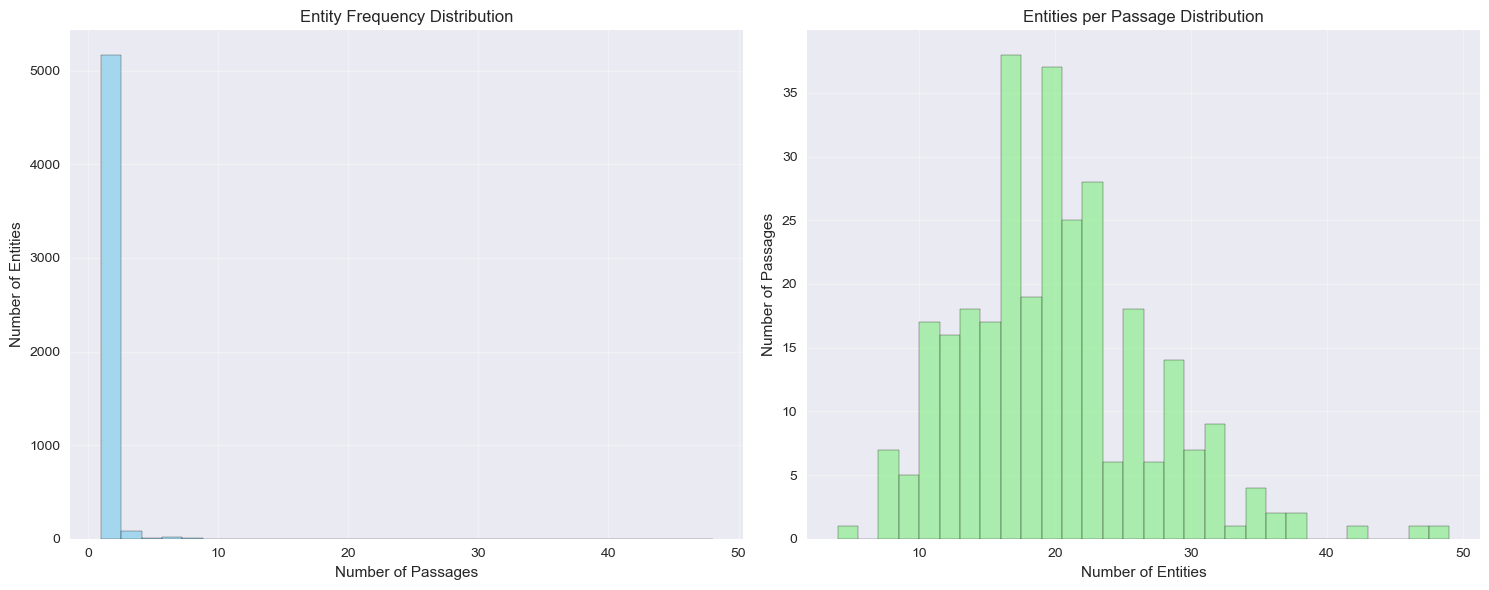


Top 15 most co-occurring entity pairs:
  (ایران, تهران): 6 times
  (امپراتور, ژاپن): 4 times
  (مدینه, هادی): 4 times
  (ایران, روم): 4 times
  (روم, نصیبین): 4 times
  (قرآن, هادی): 4 times
  (ایران, فارسی): 3 times
  (اینتر, مورینیو): 3 times
  (فارسی, یونانی): 3 times
  (اروپا, فرانسه): 3 times
  (بی‌خدایان, خدا): 3 times
  (قوی سیاه, پورتمن): 3 times
  (ایرانیان, رومیان): 3 times
  (چین, ژاپن): 3 times
  (انقلاب, ایران): 3 times


In [11]:
# Analyze entity co-occurrence in passages
entity_passages = defaultdict(set)  # entity -> set of passage IDs
passage_entities = defaultdict(set)  # passage ID -> set of entities

# Build entity-passage mappings
for item in source_triples:
    passage_id = item['id']
    entities_in_passage = set(item.get('entities', []))
    
    # Add entities from triples
    for triple in item.get('triples', []):
        entities_in_passage.add(triple['subject'])
        entities_in_passage.add(triple['object'])
    
    # Remove empty strings
    entities_in_passage = {e for e in entities_in_passage if e.strip()}
    
    passage_entities[passage_id] = entities_in_passage
    for entity in entities_in_passage:
        entity_passages[entity].add(passage_id)

# Calculate entity frequencies
entity_freq = {entity: len(passages) for entity, passages in entity_passages.items()}
sorted_entities = sorted(entity_freq.items(), key=lambda x: x[1], reverse=True)

print(f"Entity frequency analysis:")
print(f"- Total unique entities: {len(entity_freq)}")
print(f"- Entities appearing in multiple passages: {sum(1 for freq in entity_freq.values() if freq > 1)}")
print(f"- Most frequent entities:")

for entity, freq in sorted_entities[:15]:
    print(f"  {entity}: appears in {freq} passages")

# Analyze passage entity density
passage_sizes = [len(entities) for entities in passage_entities.values()]
print(f"\nPassage entity statistics:")
print(f"- Average entities per passage: {np.mean(passage_sizes):.2f}")
print(f"- Median entities per passage: {np.median(passage_sizes):.2f}")
print(f"- Max entities in a passage: {max(passage_sizes)}")
print(f"- Min entities in a passage: {min(passage_sizes)}")

# Visualize distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Entity frequency distribution
frequencies = list(entity_freq.values())
ax1.hist(frequencies, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Number of Passages')
ax1.set_ylabel('Number of Entities')
ax1.set_title('Entity Frequency Distribution')
ax1.grid(True, alpha=0.3)

# Passage entity count distribution
ax2.hist(passage_sizes, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.set_xlabel('Number of Entities')
ax2.set_ylabel('Number of Passages')
ax2.set_title('Entities per Passage Distribution')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find most co-occurring entity pairs
from itertools import combinations

cooccurrence_counts = Counter()
for entities in passage_entities.values():
    if len(entities) > 1:
        for pair in combinations(sorted(entities), 2):
            cooccurrence_counts[pair] += 1

print(f"\nTop 15 most co-occurring entity pairs:")
for (entity1, entity2), count in cooccurrence_counts.most_common(15):
    print(f"  ({entity1}, {entity2}): {count} times")